In [1]:
from prophet import Prophet
import xgboost as xgb

import sys, os, yaml, ta
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import yfinance as yf
from dateutil.relativedelta import relativedelta

from stock_forecast_module import *

import requests, zipfile, io
import pandas as pd
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

/Users/truongnguyen/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
def get_gdelt_export_for_date(date):
    date_str = date.strftime('%Y%m%d')
    url = f"http://data.gdeltproject.org/events/{date_str}.export.CSV.zip"

    try:
        response = requests.get(url, timeout=30)
        if response.status_code != 200:
            print(f"No data for {date_str}")
            return None
        
        z = zipfile.ZipFile(io.BytesIO(response.content))
        csv_name = z.namelist()[0]
        df = pd.read_csv(z.open(csv_name), sep='\t', header=None, low_memory=False)
        df['DATE'] = date
        return df
    except Exception as e:
        print(f"Error: {e}")

def filter_news(df, keywords):
    # URL is column 57; we'll drop rows without URLs
    df = df[df[57].notna()]
    filtered = df[df[57].str.contains('|'.join(keywords), case=False, na=False)]
    return filtered

def fetch_gkg_file(timestamp):
    url = f"http://data.gdeltproject.org/gkg/{timestamp}.gkg.csv.zip"
    try:
        r = requests.get(url, timeout=20)
        if r.status_code != 200:
            print(f"Not found: {timestamp}")
            return None
        z = zipfile.ZipFile(io.BytesIO(r.content))
        file_name = z.namelist()[0]
        df = pd.read_csv(z.open(file_name), sep='\t', header=None, encoding='utf-8', low_memory=False)
        df['timestamp'] = timestamp
        return df
    except Exception as e:
        print(f"Error fetching {timestamp}: {e}")
        return None

def generate_timestamps(start_date, end_date):
    timestamps = []
    current = start_date
    while current <= end_date:
        timestamps.append(current.strftime("%Y%m%d"))
        current += timedelta(days=1)
    return timestamps

def get_month_start_end(year, month):
    from datetime import datetime, timedelta
    start_date = datetime(year, month, 1)
    next_month = start_date.replace(day=28) + timedelta(days=4)  # Ensures we move to the next month
    end_date = next_month - timedelta(days=next_month.day)
    return start_date, end_date

In [3]:
# keywords = ['tesla', 'stock market', 'trump', 'congress', 'nasdaq']
# all_filtered = []

# start_date = datetime(2019, 1, 1)
# end_date = datetime(2019, 1, 3)  # extend later

# current_date = start_date
# while current_date <= end_date:
#     df = get_gdelt_export_for_date(current_date)
#     if df is not None:
#         df_filtered = filter_news(df, keywords)
#         all_filtered.append(df_filtered)
#     current_date += timedelta(days=1)

# # Combine results
# result_df = pd.concat(all_filtered, ignore_index=True)
# result_df.to_csv("filtered_gdelt_news.csv", index=False)
# print("Saved filtered news to CSV.")

In [4]:
def get_historical_news_sentiment(years_vec, months_vec):
    for yr in years_vec:
        for month in months_vec:
            # go from start of a month to end of a month
            start, end = get_month_start_end(yr, month)
            print("start date", start, "   end date", end)
            timestamps = generate_timestamps(start, end)

            all_data = []

            for ts in timestamps:
                df = fetch_gkg_file(ts)
                if df is not None:
                    all_data.append(df)

            # Combine and save
            # full_df = pd.concat(all_data, ignore_index=True)
            # full_df.to_csv("gdelt_gkg_data.csv", index=False)

            df = pd.concat(all_data, ignore_index=True)

            # df = pd.read_csv("gdelt_gkg_data.csv", encoding='utf-8', low_memory=False)
            selected_columns = [0,3,5,6,7]
            # selected_columns = ['0','3','5','6','7']
            df = df[selected_columns]
            df.columns = ['DATE', 'THEMES', 'PERSONS', 'ORGANIZATIONS', 'TONE']
            df = df.iloc[1:].reset_index(drop=True)

            # Filter for TSLA stock
            df = df[
                df['ORGANIZATIONS'].fillna('').str.contains("Tesla|Tesla Inc", case=False) |
                df['PERSONS'].fillna('').str.contains("Elon Musk", case=False) |
                df['PERSONS'].fillna('').str.contains("Trump", case=False) |
                df['THEMES'].fillna('').str.contains("Stock Market|Tech Stock Market|Tesla stock|Tesla shares|Tesla earnings|Tesla quarterly results", case=False) |
                df['THEMES'].fillna('').str.contains("Tesla forecast|Tesla revenue|Tesla market dominance", case=False) |
                df['THEMES'].fillna('').str.contains("EV|Electric vehicles|EV Market|vehicle deliveries|autopilot|full self-driving|FSD|Electricity", case=False) |
                df['THEMES'].fillna('').str.contains("Tesla Model S|Tesla Model 3|Tesla Model X|Tesla Model Y|Tesla Cybertruck|Tesla Roadster", case=False) |
                df['THEMES'].fillna('').str.contains("GDP|Unemployment|Employment", case=False) |
                df['THEMES'].fillna('').str.contains("TSLA price target|TSLA stock split|Tesla market cap|TSLA earnings report|Tesla valuation", case=False) |
                df['THEMES'].fillna('').str.contains("Tesla margins|Tesla guidance|TSLA analyst rating|short interest TSLA|Tesla institutional investors", case=False) |
                df['THEMES'].fillna('').str.contains("Tesla energy|solar roof|Tesla Powerwall|Tesla AI|Dojo supercomputer|robotaxi|autonomous driving", case=False) |
                df['THEMES'].fillna('').str.contains("Tesla software updates|neural net training|electric wall charger|battery charge stations", case=False) |
                df['THEMES'].fillna('').str.contains("AI|Artificial Intelligence|artificial intelligence|production ramp|gigafactory|battery technology|regulatory approval", case=False) |
                df['THEMES'].fillna('').str.contains("Tesla China|Tesla Berlin|Tesla Shanghai|EV tax credit|emissions regulation|trade tariffs|charging infrastructor", case=False) |
                df['THEMES'].fillna('').str.contains("Tesla vs Ford|Tesla vs BYD|Tesla vs Rivian|Tesla vs Lucid|Tesla competition", case=False) |
                df['THEMES'].fillna('').str.contains("EV race|electric vehicle market share|Tesla rivals|Tesla disruption", case=False)
            ]

            # Tone column: "averageTone,positiveScore,negativeScore,numMentions,volatility,mediaBias"
            df['SentimentScore'] = df['TONE'].str.split(',').str[0].astype(float)

            df['DATE'] = pd.to_datetime(df['DATE'], format="%Y%m%d", errors='coerce')
            df_daily_sentiment = df.groupby('DATE').agg({'SentimentScore': 'mean'}).reset_index()

            # save sentiment score (provided daily) for each month to csv file
            df_daily_sentiment.to_csv(f"./gdelt_news_sentiment/daily_news_sentiment_{yr}_{month}.csv", index=False)

def get_news_sentiment_current_month(year, month):
    # go from start of a month to end of a month
    yr = year
    start = datetime(yr, month, 1)
    end   = datetime.today() - timedelta(days=1)
    print("start date", start, "   end date", end)
    timestamps = generate_timestamps(start, end)

    all_data = []

    for ts in timestamps:
        df = fetch_gkg_file(ts)
        if df is not None:
            all_data.append(df)

    # Combine and save
    # full_df = pd.concat(all_data, ignore_index=True)
    # full_df.to_csv("gdelt_gkg_data.csv", index=False)

    df = pd.concat(all_data, ignore_index=True)

    # df = pd.read_csv("gdelt_gkg_data.csv", encoding='utf-8', low_memory=False)
    selected_columns = [0,3,5,6,7]
    # selected_columns = ['0','3','5','6','7']
    df = df[selected_columns]
    df.columns = ['DATE', 'THEMES', 'PERSONS', 'ORGANIZATIONS', 'TONE']
    df = df.iloc[1:].reset_index(drop=True)

    # Filter for TSLA stock
    df = df[
        df['ORGANIZATIONS'].fillna('').str.contains("Tesla|Tesla Inc", case=False) |
        df['PERSONS'].fillna('').str.contains("Elon Musk|Trump", case=False) |
        df['THEMES'].fillna('').str.contains("Stock Market|Tech Stock Market|Tesla stock|Tesla shares|Tesla earnings|Tesla quarterly results", case=False) |
        df['THEMES'].fillna('').str.contains("Tesla forecast|Tesla revenue|Tesla market dominance", case=False) |
        df['THEMES'].fillna('').str.contains("EV|Electric vehicles|EV Market|vehicle deliveries|autopilot|full self-driving|FSD|Electricity", case=False) |
        df['THEMES'].fillna('').str.contains("Tesla Model S|Tesla Model 3|Tesla Model X|Tesla Model Y|Tesla Cybertruck|Tesla Roadster", case=False) |
        df['THEMES'].fillna('').str.contains("GDP|Unemployment|Employment", case=False) |
        df['THEMES'].fillna('').str.contains("TSLA price target|TSLA stock split|Tesla market cap|TSLA earnings report|Tesla valuation", case=False) |
        df['THEMES'].fillna('').str.contains("Tesla margins|Tesla guidance|TSLA analyst rating|short interest TSLA|Tesla institutional investors", case=False) |
        df['THEMES'].fillna('').str.contains("Tesla energy|solar roof|Tesla Powerwall|Tesla AI|Dojo supercomputer|robotaxi|autonomous driving", case=False) |
        df['THEMES'].fillna('').str.contains("Tesla software updates|neural net training|electric wall charger|battery charge stations", case=False) |
        df['THEMES'].fillna('').str.contains("AI|Artificial Intelligence|artificial intelligence|production ramp|gigafactory|battery technology|regulatory approval", case=False) |
        df['THEMES'].fillna('').str.contains("Tesla China|Tesla Berlin|Tesla Shanghai|EV tax credit|emissions regulation|trade tariffs|charging infrastructor", case=False) |
        df['THEMES'].fillna('').str.contains("Tesla vs Ford|Tesla vs BYD|Tesla vs Rivian|Tesla vs Lucid|Tesla competition", case=False) |
        df['THEMES'].fillna('').str.contains("EV race|electric vehicle market share|Tesla rivals|Tesla disruption", case=False)
    ]

    # Tone column: "averageTone,positiveScore,negativeScore,numMentions,volatility,mediaBias"
    df['SentimentScore'] = df['TONE'].str.split(',').str[0].astype(float)

    df['DATE'] = pd.to_datetime(df['DATE'], format="%Y%m%d", errors='coerce')
    df_daily_sentiment = df.groupby('DATE').agg({'SentimentScore': 'mean'}).reset_index()

    # save sentiment score (provided daily) for each month to csv file
    df_daily_sentiment.to_csv(f"./gdelt_news_sentiment/daily_news_sentiment_{yr}_{month}.csv", index=False)

In [9]:
# years_vec = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
# months_vec= [1,2,3,4,5,6,7,8,9,10,11,12]
years_vec = [2025]
months_vec= [1,2,3,4]
# get_historical_news_sentiment(years_vec, months_vec)
get_news_sentiment_current_month(2025, 5)

start date 2025-05-01 00:00:00    end date 2025-05-18 08:32:56.894377


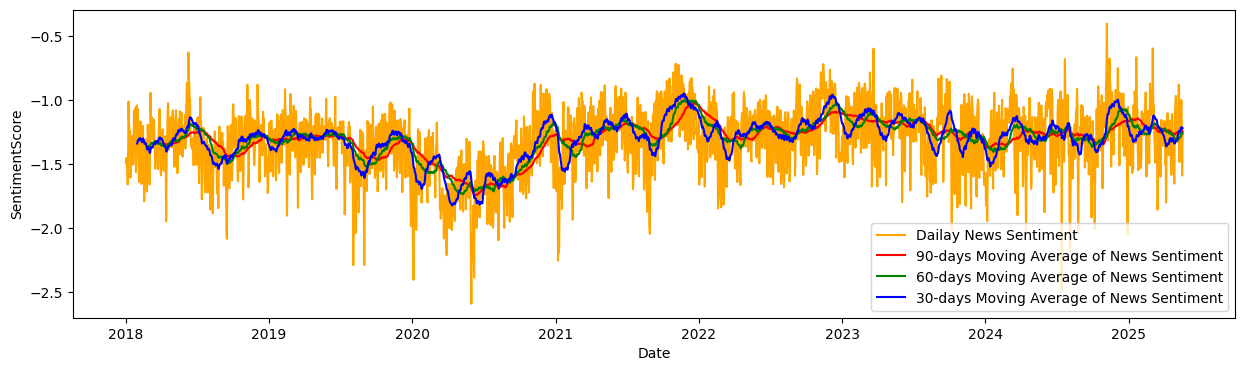

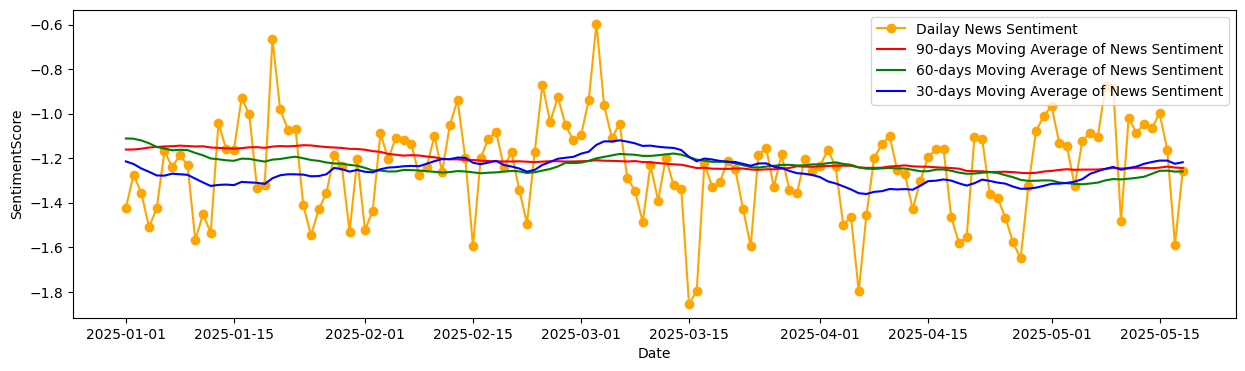

In [10]:
df, _ = extract_historical_news_sentiment([], folder_path="gdelt_news_sentiment/")
df['SentimentScore_MA90'] = df['SentimentScore'].rolling(window=90).mean()
df['SentimentScore_MA60'] = df['SentimentScore'].rolling(window=60).mean()
df['SentimentScore_MA30'] = df['SentimentScore'].rolling(window=30).mean()

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(df["ds"], df["SentimentScore"],      c='orange',label='Dailay News Sentiment')
ax.plot(df["ds"], df["SentimentScore_MA90"], c='red',   label='90-days Moving Average of News Sentiment')
ax.plot(df["ds"], df["SentimentScore_MA60"], c='green', label='60-days Moving Average of News Sentiment')
ax.plot(df["ds"], df["SentimentScore_MA30"], c='blue',  label='30-days Moving Average of News Sentiment')
ax.set_xlabel("Date")
ax.set_ylabel("SentimentScore")
ax.legend()

df_2025 = df[df['ds']>='2025-01-01'].copy(deep=True)

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(df_2025["ds"], df_2025["SentimentScore"],      c='orange',label='Dailay News Sentiment', marker='o')
ax.plot(df_2025["ds"], df_2025["SentimentScore_MA90"], c='red',   label='90-days Moving Average of News Sentiment')
ax.plot(df_2025["ds"], df_2025["SentimentScore_MA60"], c='green', label='60-days Moving Average of News Sentiment')
ax.plot(df_2025["ds"], df_2025["SentimentScore_MA30"], c='blue',  label='30-days Moving Average of News Sentiment')
ax.set_xlabel("Date")
ax.set_ylabel("SentimentScore")
ax.legend()

In [7]:
sys.exit()

SystemExit: 

WARNING - (py.warnings._showwarnmsg) - /Users/truongnguyen/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load FinBERT model (optimized for financial sentiment)
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
headlines = list(articles['title'].values)

# Load FinBERT transformer model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Run sentiment analysis
results = sentiment_pipeline(headlines)

# Create DataFrame
df = pd.DataFrame({
    "headline": headlines,
    "sentiment": [r["label"] for r in results],
    "confidence": [r["score"] for r in results]
})

In [ ]:
df.rename(columns={"headline": "title"}, inplace=True)
# Merge sentiment scores with articles
articles = articles.merge(df, on="title", how="left")
articles['publishedAt'] = pd.to_datetime(articles['publishedAt']).dt.strftime('%Y-%m-%d')
articles.rename(columns={'publishedAt': 'ds'}, inplace=True)
articles.head()

In [ ]:
# Convert sentiment to numeric score
sentiment_map = {"positive": 1, "neutral": 0, "negative": -1}
articles['sentiment_score'] = articles['sentiment'].map(sentiment_map) * articles['confidence']
# Daily average sentiment
df_daily = articles.groupby('ds')['sentiment_score'].mean().reset_index()